In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import quantile_transform

#robust_scale, scale, minmax_scale, quantile_transform

In [22]:
#import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix

In [3]:
offers_classed=pd.read_pickle("final_table_nf.pkl")

In [4]:
labels=offers_classed['successful_offer'].values
print(len(labels))

66501


In [5]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed'])
print(len(features))

66501


In [6]:
def quantileScale (df,col):
    col=df.filter(col)
    col_scaled=quantile_transform(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)

In [7]:
features.columns

Index(['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'],
      dtype='object')

In [8]:
features=quantileScale(features,['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other'])

features=features.values


In [10]:
#Convert features and labels to tensors
features = torch.as_tensor(features, dtype=torch.float)
labels = torch.as_tensor(labels, dtype=torch.long)

In [11]:
## Split data into three random datasets 

# Generate randomic indices
len_dataset = len(features)
random_idx = np.random.choice(len_dataset, len_dataset, replace=False)

# Use the proportions: train: 80%, valid: 10%, test: 10%
train_idx = random_idx[:int(len_dataset*0.8)]
valid_idx = random_idx[int(len_dataset*0.8):-int(len_dataset*0.1)]
test_idx = random_idx[-int(len_dataset*0.1):]

# Create datasets
train_dataset = TensorDataset(features[train_idx], labels[train_idx])
valid_dataset = TensorDataset(features[valid_idx], labels[valid_idx])
test_dataset = TensorDataset(features[test_idx], labels[test_idx])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
#temp=[]

#for features, labels in test_dataloader:
#    print(features)
#    llist.append(features)

In [16]:
#training labels
targ_neg = (labels[train_idx] == 0).sum()
targ_pos = (labels[train_idx] == 1).sum()
targ_total = targ_neg + targ_pos
print('Train dataset:\tNegative Class: {:5d} / {:5.2f}%\tPositive Class: {:5d} / {:5.2f}%' 
      .format(targ_neg, targ_neg*100/targ_total, targ_pos, targ_pos*100/targ_total))

#validating labels
targ_neg = (labels[valid_idx] == 0).sum()
targ_pos = (labels[valid_idx] == 1).sum()
targ_total = targ_neg + targ_pos
print('Valid dataset:\tNegative Class: {:5d} / {:5.2f}%\tPositive Class: {:5d} / {:5.2f}%' 
      .format(targ_neg, targ_neg*100/targ_total, targ_pos, targ_pos*100/targ_total))

#testing labels
targ_neg = (labels[test_idx] == 0).sum()
targ_pos = (labels[test_idx] == 1).sum()
targ_total = targ_neg + targ_pos
print('Test dataset:\tNegative Class: {:5d} / {:5.2f}%\tPositive Class: {:5d} / {:5.2f}%' 
      .format(targ_neg, targ_neg*100/targ_total,  targ_pos, targ_pos*100/targ_total))

Train dataset:	Negative Class: 30431 / 57.20%	Positive Class: 22769 / 42.80%
Valid dataset:	Negative Class:  3858 / 58.01%	Positive Class:  2793 / 41.99%
Test dataset:	Negative Class:  3774 / 56.75%	Positive Class:  2876 / 43.25%


In [17]:
#import torch
import torch.nn as nn


class LinearNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[128,128],
                 output_size=2, dropout=0.2):
        super(LinearNN, self).__init__()
        self.input_size = input_size

        nodes = []
        nodes.append(input_size)
        nodes.extend(hidden_layers)
        nodes.append(output_size)

        self.module_list = nn.ModuleList()
        for nodes_in, nodes_out in zip(nodes[:-1], nodes[1:]):
            layer = nn.Linear(nodes_in, nodes_out)
            self.module_list.append(layer)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.module_list[:-1]:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.module_list[-1](x)

        return x

In [25]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        y_true = []
        y_pred = []
        for features, labels in dataloader:
            prediction = model(features)
            
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            valid_loss += criterion(prediction, labels)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            y_pred.extend(prediction.view(-1))
            y_true.extend(labels.view(-1))

        # normalize the loss
        valid_loss /= len(dataloader)
        valid_loss = valid_loss.item()

        # Calculate the metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, pos_label=1, average='binary')
        precision = precision_score(y_true, y_pred, pos_label=1, average='binary')
        recall = recall_score(y_true, y_pred, pos_label=1, average='binary')
        recall0 = recall_score(y_true, y_pred, pos_label=0, average='binary')
        recall_avg= recall_score(y_true, y_pred,  average='micro')
        con_mat = confusion_matrix(y_true, y_pred)
#        fpr, tpr, thresholds_keras = roc_curve(y_true, y_pred)
#        auc_ = auc(fpr, tpr)
        roc_auc=roc_auc_score(y_true, y_pred)
        

        model.train()

        return valid_loss, f1, accuracy, precision, recall, recall0, recall_avg, roc_auc, con_mat
    
  
  #  print("auc_keras:" + str(auc_))

In [26]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, labels) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        
        # LR scheduler step
        lr_scheduler.step(train_loss[-1])

        # Validate
        metrics = validate(model)
        valid_loss.append(metrics[0])
        print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalidation loss: {:7.4f}' \
              .format(epoch, train_loss[-1], valid_loss[-1]))

        # Save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

In [27]:
#30457 / 57.25%	Positive Class: 22743 

In [28]:
linear_classifier = LinearNN(
    input_size=18, output_size=2, hidden_layers=[128,128,128])
criterion = nn.CrossEntropyLoss(
    torch.tensor([(30431. / 22769.), 2])) #change this 2nd variable to change precision/recall threshold
optimizer = torch.optim.Adam(
    linear_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=15, verbose=True)

In [29]:
%%time 
#200 takes 15min 20s

linear_loss = train(linear_classifier,
                    model_name='linear_classifier',
                    epochs=10)

Epoch    1	train loss:  0.6792	validation loss:  0.6335
Epoch    2	train loss:  0.6357	validation loss:  0.6181
Epoch    3	train loss:  0.6232	validation loss:  0.6118
Epoch    4	train loss:  0.6141	validation loss:  0.6039
Epoch    5	train loss:  0.6089	validation loss:  0.5966
Epoch    6	train loss:  0.6031	validation loss:  0.5925
Epoch    7	train loss:  0.5993	validation loss:  0.5914
Epoch    8	train loss:  0.5950	validation loss:  0.5843
Epoch    9	train loss:  0.5907	validation loss:  0.5839
Epoch   10	train loss:  0.5880	validation loss:  0.5810
CPU times: user 2min 17s, sys: 137 ms, total: 2min 18s
Wall time: 44.1 s


In [34]:

## Test models

loss, f1, acc, prec, recall, recall0, recall_avg, roc_auc, con_mat =  validate(linear_classifier, test_dataloader)

In [36]:
print("the loss function is: {:0.4f}".format(loss))
print("the f1 score is: {:0.4f}".format(f1))
print("the accuracy is: {:0.4f}".format(acc))
print("the precision is: {:0.4f}".format(prec))
print("the recall is: {:0.4f}".format(recall))
print("the recall for negs is: {:0.4f}".format(recall0))
print("the recall average is: {:0.4f}".format(recall_avg))
print("the roc_auc is: {:0.4f}".format(roc_auc))

#0.5521186590194702

the loss function is: 0.5839
the f1 score is: 0.6656
the accuracy is: 0.6639
the precision is: 0.5842
the recall is: 0.7733
the recall for negs is: 0.5806
the recall average is: 0.6639
the roc_auc is: 0.6769


<AxesSubplot:>

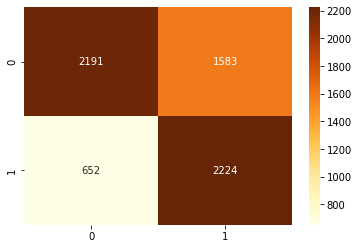

In [37]:
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

<AxesSubplot:>

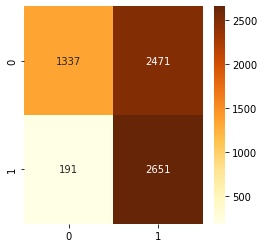

In [98]:
plt.figure(figsize = (4,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')